In [16]:
{'a' : 2, 'b': 3}.keys() & 'c'

set()

In [42]:
import pymc as pm
import seaborn as sns
import statsmodels.formula.api as smf
import arviz as az
from matplotlib import pyplot

In [54]:
with pm.Model() as gen_model:
    γ = pm.Normal("motivation", 0, 1)
    behavior_noisiness = pm.MutableData("behavior_noisiness", 0.2)
    θ = pm.Binomial("week_1_engagement", p = pm.math.invlogit(γ), n=7)
    #θ = pm.Normal("week_1_engagement", mu=γ, sigma=behavior_noisiness)
    T = pm.Bernoulli("uses_feature", p = pm.math.invlogit(γ))
    ATE = pm.MutableData('ATE', 0)
    β = pm.MutableData("Motivation impact", 2.0)
    p = pm.Deterministic("success_probability", pm.math.invlogit(β*γ + ATE * T))
    y = pm.Bernoulli("outcome", p = p)

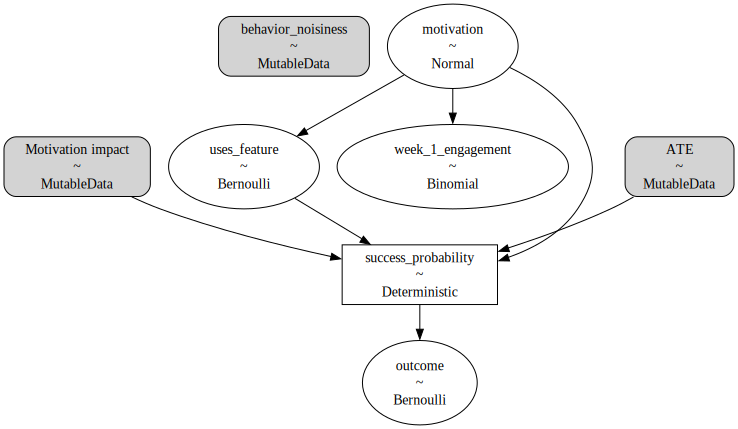

In [58]:
pm.model_to_graphviz(gen_model)

In [59]:
with gen_model:
    samples = pm.sample_prior_predictive(samples=10_000)

Sampling: [motivation, outcome, uses_feature, week_1_engagement]


In [60]:
df = samples['prior'].to_dataframe().reset_index()

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='motivation', ylabel='Count'>

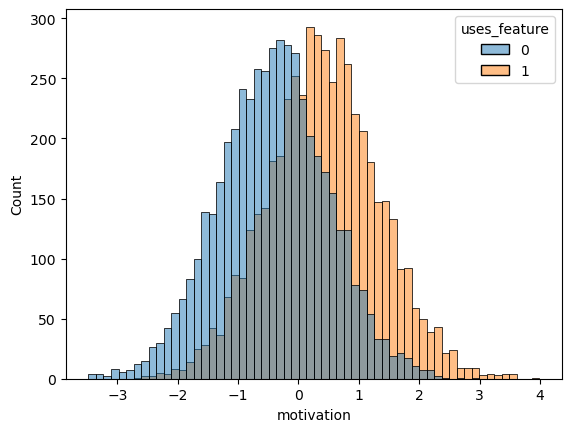

In [61]:
sns.histplot(df, x='motivation', hue='uses_feature')

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='motivation', ylabel='week_1_engagement'>

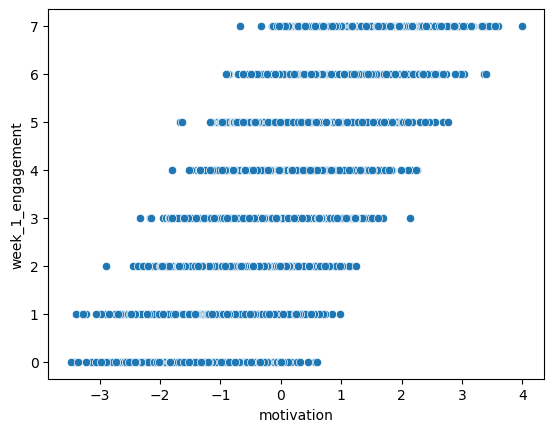

In [62]:
sns.scatterplot(data=df, x='motivation', y='week_1_engagement')

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='motivation', ylabel='Count'>

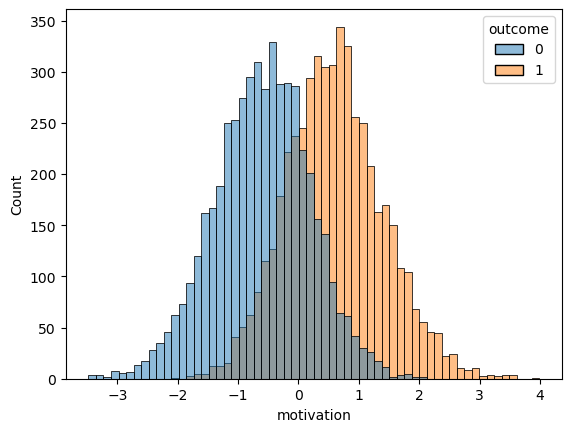

In [63]:
sns.histplot(data=df, x='motivation', hue='outcome')

In [64]:
from sklearn.linear_model import LogisticRegression

df["pscore"] = LogisticRegression(penalty=None).fit(
    y=df["uses_feature"], X=df["week_1_engagement"].values.reshape(-1, 1)
).predict_proba(df['week_1_engagement'].values.reshape(-1, 1))[:,1]

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='pscore', ylabel='Count'>

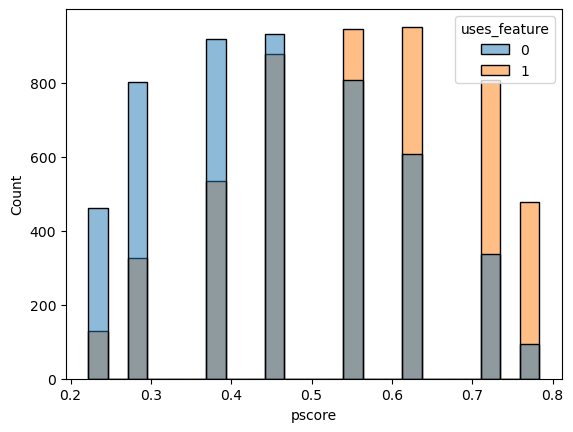

In [65]:
sns.histplot(data=df, x='pscore', hue='uses_feature')

In [66]:
new_df = df

In [67]:
w = 1 / (new_df["pscore"] * new_df["uses_feature"] + (1-new_df["pscore"]) * (1-new_df["uses_feature"]))
smf.wls("outcome ~ uses_feature", weights=w, data=new_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4455,0.007,63.346,0.000,0.432,0.459
uses_feature,0.1118,0.010,11.250,0.000,0.092,0.131


In [75]:
with pm.Model(
    coords= {
        'i': df['draw']
    }
) as pred_model:
    γ = pm.Normal("motivation", 0, 1, dims='i')
        
    η = pm.HalfNormal('η', 0.5)
    #θ = pm.Normal("week_1_engagement", mu=η * γ, sigma=0.5, observed=df['week_1_engagement'])
    θ = pm.Binomial("week_1_engagement", p=pm.math.invlogit(η*γ), observed=df['week_1_engagement'], n=7)
    
    ζ = pm.Normal('ζ', 0, 0.5)
    β = pm.HalfNormal('β', 0.5)

    p = pm.Deterministic("success_probability", pm.math.invlogit(
        #α[1] + 
        β*γ + ζ * df['uses_feature']
    ))

    pm.Deterministic('ATE', 
        pm.math.invlogit(
            #α[1] +
             ζ + γ.mean() * β) - 
        pm.math.invlogit(
            #α[1] + 
            γ.mean() * β)
    )
    
    y = pm.Bernoulli("outcome", p = p, observed=df['outcome'])

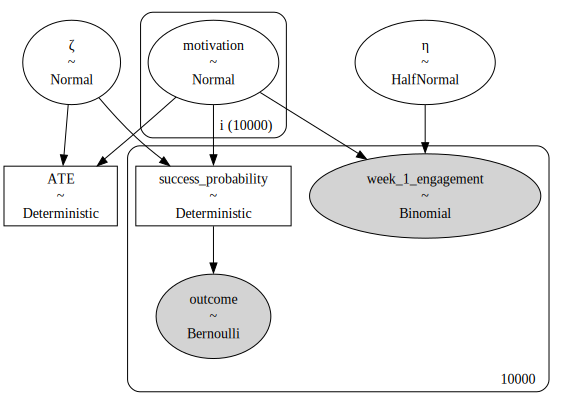

In [76]:
pm.model_to_graphviz(pred_model)

In [77]:
with pred_model:
    trace = pm.sample(nuts_sampler='nutpie')

In [79]:
vrs = ['ATE', 'η', 'ζ', 'β']
az.summary(trace, var_names=vrs)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ATE,0.085,0.010,0.065,0.103,0.000,0.0,5506.0,2924.0,1.0
η,1.013,0.015,0.985,1.040,0.000,0.0,1667.0,2069.0,1.0
ζ,0.341,0.042,0.262,0.419,0.001,0.0,5516.0,3092.0,1.0


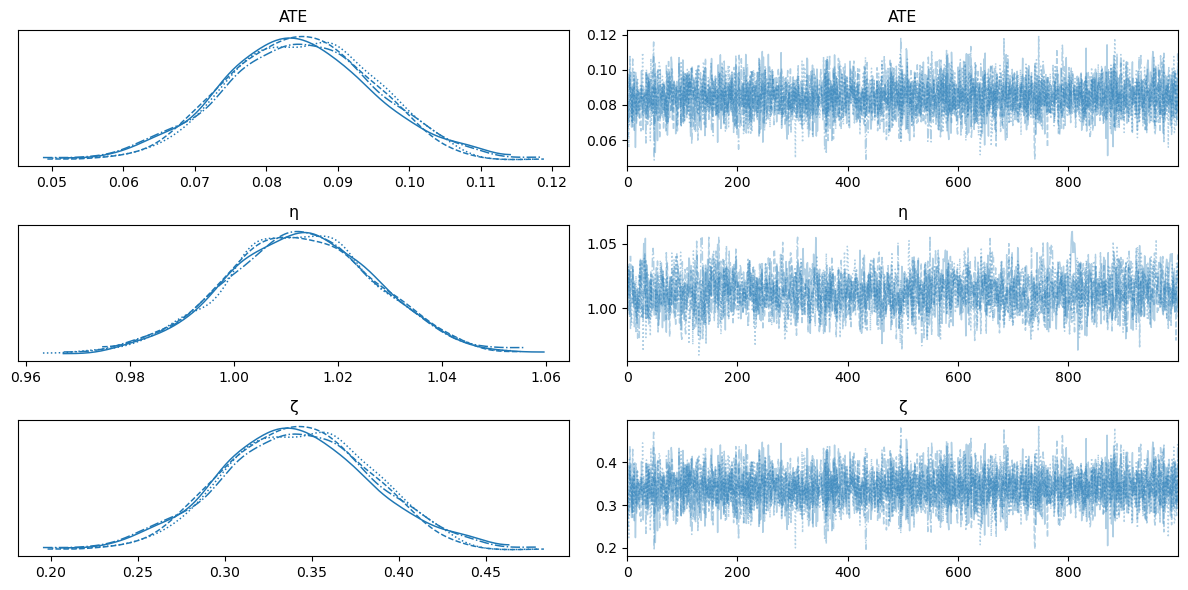

In [80]:
az.plot_trace(trace, var_names=vrs)
pyplot.tight_layout()
